In [1]:
import zipfile
import pandas as pd
import io
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import StratifiedShuffleSplit
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping

In [2]:
# Path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/archive.zip'

In [3]:
# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
# Load the extracted CSV file into a pandas DataFrame
df = pd.read_csv('/content/IMDB Dataset.csv')

In [5]:
df.shape

(50000, 2)

In [6]:
# Display the first few rows
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# Loop through the first 5 entries in the dataset
for i in range(5):
    print("Review ", [i])
    print(df['review'].iloc[i], '\n')
    print("Sentiment ", [i])
    print(df['sentiment'].iloc[i], '\n\n')

Review  [0]
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is du

In [8]:
# Display a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [9]:
# Define a function to count the number of words
def word_count(text):
    return len(text.split())

# Apply the function to the review column
df['word_count'] = df['review'].apply(word_count)


In [10]:
df.head()

,review,sentiment,word_count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


(array([1.0433e+04, 9.3360e+03, 3.0110e+03, 1.1820e+03, 5.2200e+02,
        3.0200e+02, 2.0300e+02, 5.0000e+00, 3.0000e+00, 3.0000e+00]),
 array([   4. ,  155.8,  307.6,  459.4,  611.2,  763. ,  914.8, 1066.6,
        1218.4, 1370.2, 1522. ]),
 <BarContainer object of 10 artists>)

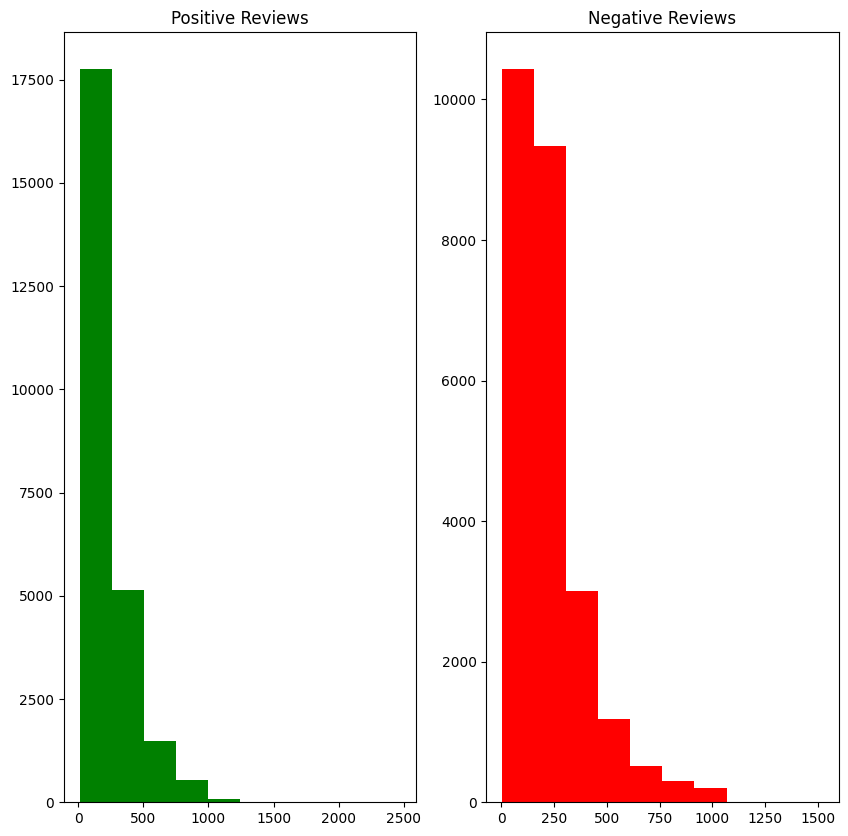

In [11]:
# Create histograms of word counts for positive and negative reviews in two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].hist(df[df['sentiment'] == 'positive']['word_count'], color='green', label='Positive Reviews')
ax[0].set_title('Positive Reviews')
ax[1].set_title('Negative Reviews')
ax[1].hist(df[df['sentiment'] == 'negative']['word_count'], color='red', label='Negative Reviews')

In [12]:
# Display the number of missing values in each column of the DataFrame
df.isnull().sum()


,0
review,0
sentiment,0
word_count,0


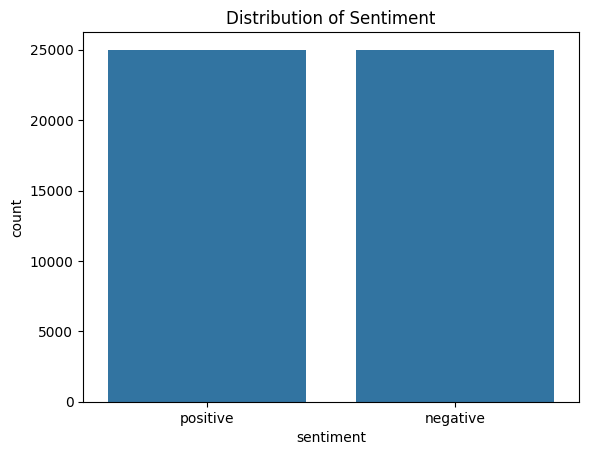

In [13]:
# Create a count plot to visualize the distribution of sentiments in the dataset
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiment')
plt.show()


In [14]:
print(df.duplicated().sum())

418


In [15]:
# Remove duplicate reviews from the DataFrame
df = df.drop_duplicates('review')


In [16]:
df.reset_index(drop=False, inplace=True)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49582 entries, 0 to 49581
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       49582 non-null  int64 
 1   review      49582 non-null  object
 2   sentiment   49582 non-null  object
 3   word_count  49582 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [18]:
# Download the NLTK stopwords and WordNet data
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# Create a set of English stopwords and initialize a WordNet lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [20]:
# Define a function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

# Apply the preprocess_text function to the 'review' column
df['review'] = df['review'].apply(preprocess_text)

In [21]:
df.head()

,index,review,sentiment,word_count
0,0,one reviewer mentioned watching 1 oz episode h...,positive,307
1,1,wonderful little production br br filming tech...,positive,162
2,2,thought wonderful way spend time hot summer we...,positive,166
3,3,basically family little boy jake think zombie ...,negative,138
4,4,petter mattei love time money visually stunnin...,positive,230


In [22]:
#checking to be sure
df['review'][0]

'one reviewer mentioned watching 1 oz episode hooked right exactly happened br br first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word br br called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away br br would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison expe

In [23]:
# Tokenize the text data, fit the tokenizer on the reviews, convert the reviews to sequences of integers, and pad the sequences to ensure they all have the same length.
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['review'])
X = tokenizer.texts_to_sequences(df['review'])
X = pad_sequences(X, maxlen=500)


In [24]:
# Convert sentiment labels to binary values: 1 for positive and 0 for negative
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)


In [25]:
# Initialize the StratifiedShuffleSplit to create a single split with 15% of the data as the test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1)

In [26]:
# Split the data
for train_index, test_index in split.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [27]:
print(y_train.value_counts())
print(y_test.value_counts())

sentiment
1    22395
0    22228
Name: count, dtype: int64
sentiment
1    2489
0    2470
Name: count, dtype: int64


In [28]:
# Build a sequential model with embedding, bidirectional LSTM layers, dropout layers, and a dense output layer.
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [29]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [30]:
# Train the model on the training data using 20% of the training data for validation
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.1,shuffle=True, callbacks=[early_stopping])

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 214ms/step - accuracy: 0.7066 - loss: 0.5364 - val_accuracy: 0.8875 - val_loss: 0.2814
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step - accuracy: 0.9116 - loss: 0.2380 - val_accuracy: 0.8895 - val_loss: 0.2806
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9343 - loss: 0.1823 - val_accuracy: 0.8929 - val_loss: 0.2904
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9526 - loss: 0.1384 - val_accuracy: 0.8900 - val_loss: 0.3154
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 213ms/step - accuracy: 0.9622 - loss: 0.1109 - val_accuracy: 0.8817 - val_loss: 0.3321


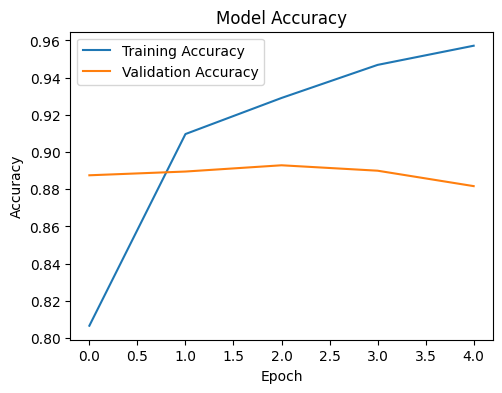

In [31]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

In [32]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8837 - loss: 0.2811
Test Accuracy: 88.49%


In [33]:
# Make predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


In [34]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      2470
           1       0.85      0.94      0.89      2489

    accuracy                           0.88      4959
   macro avg       0.89      0.88      0.88      4959
weighted avg       0.89      0.88      0.88      4959



In [35]:
# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[2048  422]
 [ 149 2340]]
